## Importing the libraries

In [134]:
import plaidml.keras
plaidml.keras.install_backend()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

import math

# import pyflux as pf

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
#from keras.layers import Concatenate
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pickle

from numpy.random import seed

from tensorflow import set_random_seed

In [135]:
seed(2019)
set_random_seed(2019)

## Helper Functions

In [136]:
def calc_RMSE(validation_data, prediction_data):
   """
   Calculate RMSE
   """
   a = np.array(validation_data)
   b = np.array(prediction_data)

   return np.sqrt(np.mean((b-a)**2))

In [137]:
def get_fuller_test(series):
    values = series.values
    result = adfuller(values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [138]:
def make_plots(data, lags=None):
    '''
    plotting the data with specified number of lags.
    plotting raw data, then ACF and PACF
    '''
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax = raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags = lags, ax = acf)
    smt.graphics.plot_pacf(data, lags = lags, ax = pacf)
    sns.despine()
    plt.tight_layout()

In [139]:
def make_plots_2(data, lags=None):
    '''
    plotting rolling mean, rolling std and original as per number of lags
    '''
    rolling_mean = data.rolling(window = lags).mean()
    rolling_std = data.rolling(window = lags).std()
    
    original = plt.plot(data, color='black',label = 'Original Timeseries')
    mean = plt.plot(rolling_mean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolling_std, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Original, Rolling Mean, Standard Deviation')
    sns.despine()
    plt.show()

In [146]:
def split_train_test_chronological(df, ratio = 0.9, use_ratio = True, index = 1000):
    
    '''
    Input is a dataframe, and a ratio. Splits dataframe into 2 dataframes chronologically.
    Returns first dataframe up to the index of the length of the input dataframe times the input ratio, 
    and returns second dataframe of remaining elements.
    use_ratio is a flag, wether ratio should be used or indicies instead.
    
    df = input dataframe
    ratio = ratio to be used for splitting
    use_ratio = if True, use ratio, 
    index = index to split input dataframe on
    
    '''
    if use_ratio:
        size = len(df) * ratio
        size_round = round(size)

        df_train = df[0:(size_round)]
        df_test = df[size_round:]
    else:
        df_train = df[0:(index)]
        df_test = df[index:]
    return df_train, df_test

## Importing data

In [141]:
df_bitcoin_inter = pd.read_pickle('./processed_data/df_bitcoin_inter.pickle')
df_gold_inter = pd.read_pickle('./processed_data/df_gold_inter.pickle')
df_vix_inter = pd.read_pickle('./processed_data/df_vix_inter.pickle')

### Train Test Validation split using helper function

In [142]:
df_train = df_bitcoin_inter.copy()

In [143]:
df_train['vix'] = df_vix_inter['y']

In [144]:
df_train['gold'] = df_gold_inter['y']

In [145]:
df_train.head(2)

,ds,y,vix,gold
0,2017-02-08 00:00:00,1054.03,18.879,2732.0
1,2017-02-08 01:00:00,1060.48,18.915,2693.0


In [57]:
# df_train_vix, df_test_vix = split_train_test_chronological(df_vix_inter, 0.98)

In [58]:
# df_train_vix, df_test_vix = split_train_test_chronological(df_vix_inter, 0.98)

In [59]:
# df_train_vix, df_val_vix = split_train_test_chronological(df_train_vix.reset_index(), 0.98)

In [60]:
# df_train_vix, df_val_vix = split_train_test_chronological(df_train_vix.reset_index(), 0.98)

## FB Prophet Baseline

In [55]:
proph = Prophet()

In [56]:
proph.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [57]:
forecast = proph.predict(df_val)

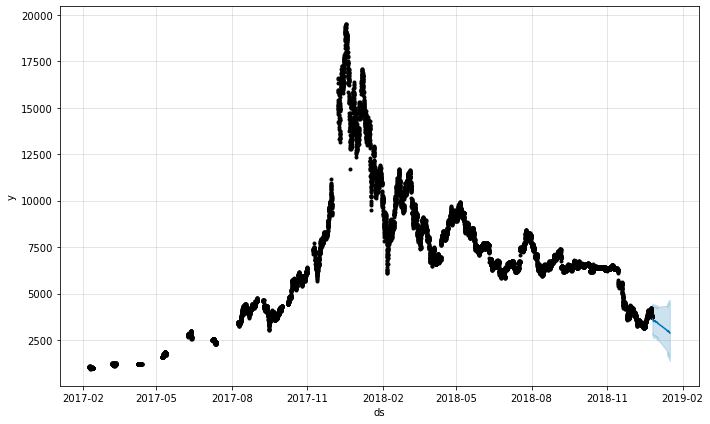

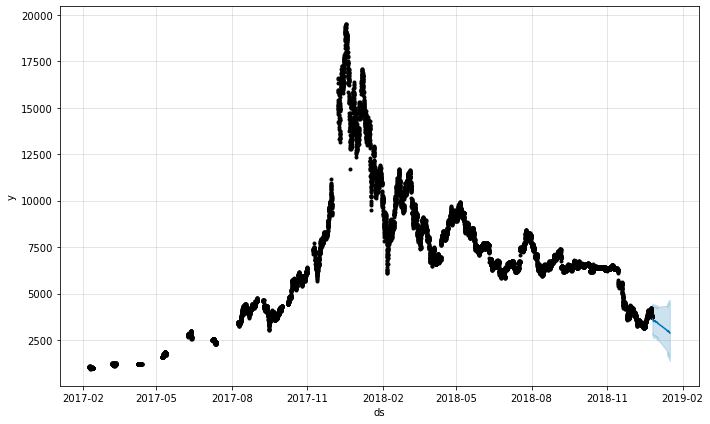

In [58]:
proph.plot(forecast)

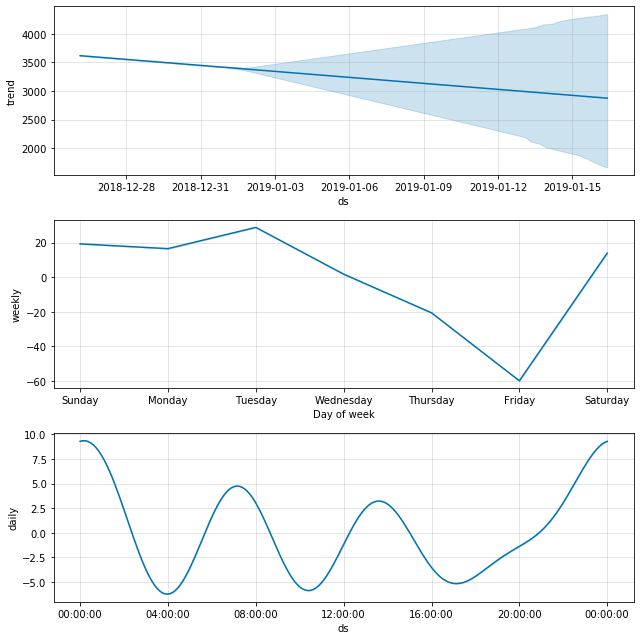

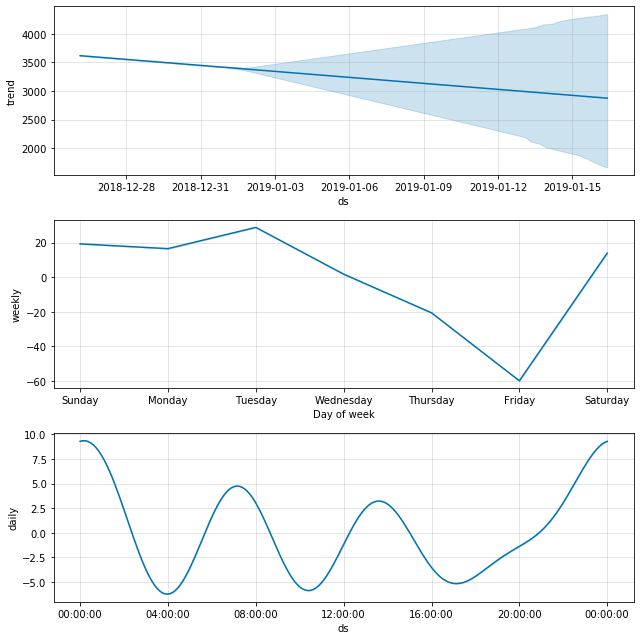

In [59]:
proph.plot_components(forecast)

In [60]:
df_fb = df_bitcoin_inter.copy()
df_fb.reset_index(inplace = True)

In [61]:
df_fb.drop(['index'],axis = 1,inplace = True)

In [62]:
# df_fb.ds.value_counts()

In [63]:
df_vix_inter.reset_index(inplace = True)

In [64]:
df_vix_inter.drop(['index'],axis = 1,inplace = True)

In [65]:
df_fb['vix'] = df_vix_inter['y']

In [66]:
proph_with_vix = Prophet()

In [67]:
proph_with_vix.add_regressor('vix')

In [68]:
proph_with_vix.fit(df_fb)

## Baseline ARIMA model

In [69]:
model = ARIMA(df_train.y, order=(1,0,1)).fit()

### Window refitting model

The make_window_refitting_ARIMA_model is taking a really long time to train, as it is retraining for every new observation.

In [216]:
def make_window_refitting_ARIMA_model(df_t = df_train['y'] , df_v = df_val['y'],p = 1, d = 1, q = 0):
    preds = []
    df_t = list(df_t)

    for i in df_v:
        model = ARIMA(df_t, order=(p,d,q)).fit()
        pred = model.forecast()[0][0]
        preds.append(pred)
        df_t.append(i)

    plt.plot(df_v)
    plt.plot(preds)
    rmse = calc_RMSE(validation,np.array(preds))
    print(rmse)
    
    return rmse,df_v,preds,model

In [34]:
# res = make_window_refitting_model(df_t = df_train['y'], p = 1, d = 0 , q = 1)

In [ ]:
df_val;

## Baseline LSTM Model

In [61]:
# date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_train.columns[1:]]),
#                           data=[i for i in range(len(df_train.columns[1:]))])

# series_array = df_train[df_train.columns[1:]].values

In [62]:
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

In [63]:
def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

In [64]:
def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [67]:
def split_sequence(sequence, n_steps = 72):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [80]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Standradizing for LSTM

In [103]:
df_train.head(2)

,ds,y,vix,gold
0,2017-02-08 00:00:00,1054.03,18.879,2732.0
1,2017-02-08 01:00:00,1060.48,18.915,2693.0


In [107]:
df_train.tail(2)

,ds,y,vix,gold
12666,2019-06-01 22:00:00,8568.81,30.447,3561.58
12667,2019-06-01 23:00:00,8560.63,30.447,3569.34


In [104]:
# load dataset
values = df_train.drop('ds', axis = 1).values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)


reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
7,0.005247,0.179461,0.003901,0.005594,0.180275,0.001623,0.005727,0.179032,0.002740,0.005882,...,0.004491,0.005908,0.179438,0.004092,0.005895,0.179642,0.003908,0.005905,0.179642,0.003899
8,0.005594,0.180275,0.001623,0.005727,0.179032,0.002740,0.005882,0.176997,0.004602,0.006007,...,0.004092,0.005895,0.179642,0.003908,0.005905,0.179642,0.003899,0.004164,0.179642,0.002629
9,0.005727,0.179032,0.002740,0.005882,0.176997,0.004602,0.006007,0.176997,0.004491,0.005908,...,0.003908,0.005905,0.179642,0.003899,0.004164,0.179642,0.002629,0.004071,0.179642,0.003160
10,0.005882,0.176997,0.004602,0.006007,0.176997,0.004491,0.005908,0.179438,0.004092,0.005895,...,0.003899,0.004164,0.179642,0.002629,0.004071,0.179642,0.003160,0.004373,0.179642,0.003959
11,0.006007,0.176997,0.004491,0.005908,0.179438,0.004092,0.005895,0.179642,0.003908,0.005905,...,0.002629,0.004071,0.179642,0.003160,0.004373,0.179642,0.003959,0.004777,0.179642,0.003199


In [108]:
# drop columns we don't want to predict
y = reframed.iloc[:,-11].values
X = reframed.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]

test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 23) (12000,) (341, 1, 23) (341,) (320, 1, 23) (320,)


In [68]:
# std = StandardScaler()

In [69]:
# train = df_train.copy()
# train.head()

,ds,y,vix,gold
0,2017-02-08 00:00:00,1054.03,18.879,2732.00
1,2017-02-08 01:00:00,1060.48,18.915,2693.00
2,2017-02-08 02:00:00,1062.94,18.860,2712.12
3,2017-02-08 03:00:00,1065.82,18.770,2743.99
4,2017-02-08 04:00:00,1068.15,18.770,2742.10


In [70]:
# train.set_index('ds', inplace = True)

In [71]:
num_steps = 72
# n_features = 3

In [72]:
#  # train = df_train.copy()

# train = np.array(df_train.y)[:, np.newaxis]
# val = df_val.copy()
# val = np.array(val.y)[:, np.newaxis]
# std.fit(train)

# val = std.transform(val)
# train = std.transform(train)

In [73]:
# train_vix = np.array(df_train.vix)[:, np.newaxis]

# val_vix = np.array(df_val.vix)[:, np.newaxis]
# std.fit(train_vix)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [74]:
# train_gold = np.array(df_train.gold)[:, np.newaxis]

# val_gold = np.array(df_val.gold)[:, np.newaxis]
# std.fit(train_gold)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [142]:
# X, y = split_sequence(train, num_steps)

In [143]:
# X = X.reshape((X.shape[0], X.shape[1], n_features))

ValueError: cannot reshape array of size 870840 into shape (12095,72,3)

In [107]:
# X.shape

NameError: name 'X' is not defined

In [683]:
# X_val, y_val = split_sequence(val, n_steps)

In [109]:
# X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [112]:
LSTM_model_1 = Sequential()
LSTM_model_1.add(LSTM(16, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# LSTM_model_1.add(Dense(8))
# LSTM_model_1.add(LSTM(16, activation='relu'))
LSTM_model_1.add(Dense(1))
LSTM_model_1.compile(optimizer='adam', loss='mse')

In [111]:
LSTM_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [126]:
# history = LSTM_model_1.fit(train, train.y, epochs=100, batch_size=128, validation_split=0.25)

In [114]:
history = LSTM_model_1.fit(train_X, train_y, 
                    epochs= 200, 
                    batch_size = 128, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 341 samples
Epoch 1/200
 - 5s - loss: 0.0835 - val_loss: 0.1309
Epoch 2/200
 - 1s - loss: 0.0838 - val_loss: 0.0961
Epoch 3/200
 - 1s - loss: 0.0126 - val_loss: 0.0057
Epoch 4/200
 - 1s - loss: 0.0019 - val_loss: 0.0034
Epoch 5/200
 - 1s - loss: 0.0016 - val_loss: 0.0019
Epoch 6/200
 - 1s - loss: 0.0013 - val_loss: 0.0011
Epoch 7/200
 - 1s - loss: 0.0011 - val_loss: 6.4213e-04
Epoch 8/200
 - 1s - loss: 9.8817e-04 - val_loss: 3.9073e-04
Epoch 9/200
 - 1s - loss: 8.9912e-04 - val_loss: 2.7095e-04
Epoch 10/200
 - 1s - loss: 8.3944e-04 - val_loss: 2.1642e-04
Epoch 11/200
 - 1s - loss: 7.9825e-04 - val_loss: 1.9298e-04
Epoch 12/200
 - 1s - loss: 7.6839e-04 - val_loss: 1.8328e-04
Epoch 13/200
 - 1s - loss: 7.4437e-04 - val_loss: 1.7950e-04
Epoch 14/200
 - 1s - loss: 7.2331e-04 - val_loss: 1.7805e-04
Epoch 15/200
 - 1s - loss: 7.0288e-04 - val_loss: 1.7744e-04
Epoch 16/200
 - 1s - loss: 6.8252e-04 - val_loss: 1.7698e-04
Epoch 17/200
 - 1s - loss: 6.6241e-04

Epoch 137/200
 - 1s - loss: 4.4607e-04 - val_loss: 0.0013
Epoch 138/200
 - 1s - loss: 2.4212e-04 - val_loss: 8.4383e-04
Epoch 139/200
 - 1s - loss: 1.6285e-04 - val_loss: 5.5269e-04
Epoch 140/200
 - 1s - loss: 1.3258e-04 - val_loss: 3.7200e-04
Epoch 141/200
 - 1s - loss: 1.2603e-04 - val_loss: 2.5642e-04
Epoch 142/200
 - 1s - loss: 1.3542e-04 - val_loss: 1.8164e-04
Epoch 143/200
 - 1s - loss: 1.5816e-04 - val_loss: 1.3425e-04
Epoch 144/200
 - 1s - loss: 2.1068e-04 - val_loss: 1.0393e-04
Epoch 145/200
 - 1s - loss: 2.4607e-04 - val_loss: 9.2421e-05
Epoch 146/200
 - 1s - loss: 3.5845e-04 - val_loss: 9.7041e-05
Epoch 147/200
 - 1s - loss: 1.1809e-04 - val_loss: 9.7355e-05
Epoch 148/200
 - 1s - loss: 4.2629e-04 - val_loss: 1.0170e-04
Epoch 149/200
 - 1s - loss: 4.7929e-04 - val_loss: 1.3537e-04
Epoch 150/200
 - 1s - loss: 8.0800e-04 - val_loss: 2.3594e-04
Epoch 151/200
 - 1s - loss: 0.0010 - val_loss: 3.6371e-04
Epoch 152/200
 - 1s - loss: 0.0012 - val_loss: 5.1972e-04
Epoch 153/200
 - 1s 

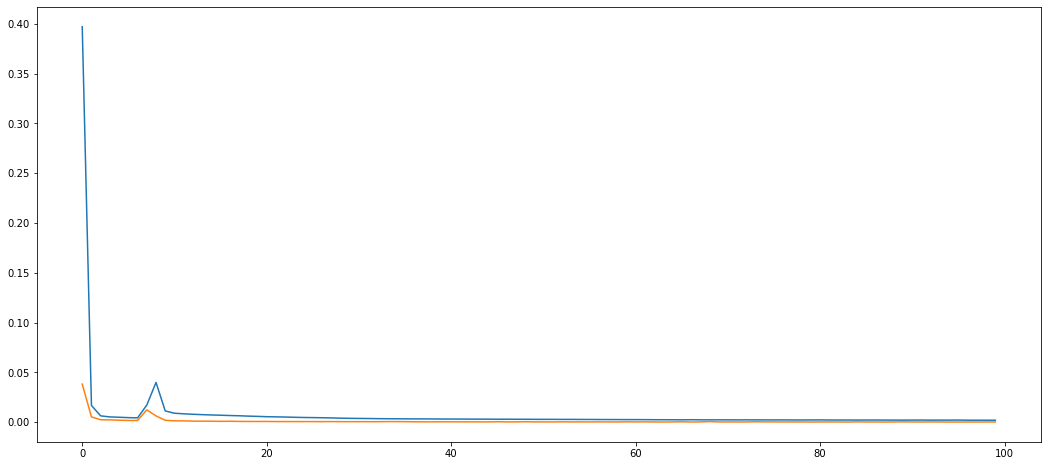

In [688]:
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [119]:


LSTM_model_2 = Sequential()
LSTM_model_2.add(LSTM(16, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# LSTM_model_2.add(Dense(8))
# LSTM_model_2.add(LSTM(16, activation='relu'))
LSTM_model_2.add(Dense(1))
LSTM_model_2.compile(optimizer='adam', loss='mse')

In [120]:
# history_2 = LSTM_model_2.fit(X, y, epochs=100, batch_size=128, validation_data=(X_val, y_val))

In [121]:
history_2 = LSTM_model_2.fit(train_X, train_y, 
                    epochs= 300, 
                    batch_size = 128, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 341 samples
Epoch 1/300
 - 1s - loss: 0.1104 - val_loss: 0.1445
Epoch 2/300
 - 1s - loss: 0.0914 - val_loss: 0.1228
Epoch 3/300
 - 1s - loss: 0.0252 - val_loss: 0.0322
Epoch 4/300
 - 1s - loss: 0.0101 - val_loss: 0.0104
Epoch 5/300
 - 1s - loss: 0.0019 - val_loss: 0.0031
Epoch 6/300
 - 1s - loss: 0.0013 - val_loss: 0.0017
Epoch 7/300
 - 1s - loss: 0.0013 - val_loss: 0.0010
Epoch 8/300
 - 1s - loss: 0.0012 - val_loss: 6.3720e-04
Epoch 9/300
 - 1s - loss: 0.0011 - val_loss: 4.0920e-04
Epoch 10/300
 - 1s - loss: 0.0010 - val_loss: 2.7967e-04
Epoch 11/300
 - 1s - loss: 9.6258e-04 - val_loss: 2.0910e-04
Epoch 12/300
 - 1s - loss: 9.2748e-04 - val_loss: 1.7351e-04
Epoch 13/300
 - 1s - loss: 9.0099e-04 - val_loss: 1.5911e-04
Epoch 14/300
 - 1s - loss: 8.8085e-04 - val_loss: 1.5461e-04
Epoch 15/300
 - 1s - loss: 8.6590e-04 - val_loss: 1.5658e-04
Epoch 16/300
 - 1s - loss: 8.5452e-04 - val_loss: 1.5914e-04
Epoch 17/300
 - 1s - loss: 8.4823e-04 - val_loss: 1.6

Epoch 137/300
 - 1s - loss: 2.8525e-04 - val_loss: 1.3065e-04
Epoch 138/300
 - 1s - loss: 1.3684e-04 - val_loss: 9.4154e-05
Epoch 139/300
 - 1s - loss: 2.1547e-04 - val_loss: 9.2951e-05
Epoch 140/300
 - 1s - loss: 7.8307e-05 - val_loss: 1.2343e-04
Epoch 141/300
 - 1s - loss: 1.7831e-04 - val_loss: 9.7711e-05
Epoch 142/300
 - 1s - loss: 1.0066e-04 - val_loss: 1.0312e-04
Epoch 143/300
 - 1s - loss: 1.9918e-04 - val_loss: 8.6656e-05
Epoch 144/300
 - 1s - loss: 9.8076e-05 - val_loss: 9.5136e-05
Epoch 145/300
 - 1s - loss: 2.1196e-04 - val_loss: 8.4547e-05
Epoch 146/300
 - 1s - loss: 1.1393e-04 - val_loss: 8.4008e-05
Epoch 147/300
 - 1s - loss: 1.7188e-04 - val_loss: 8.6436e-05
Epoch 148/300
 - 1s - loss: 9.7637e-05 - val_loss: 8.0008e-05
Epoch 149/300
 - 1s - loss: 9.9331e-05 - val_loss: 8.6429e-05
Epoch 150/300
 - 1s - loss: 8.1864e-05 - val_loss: 8.6072e-05
Epoch 151/300
 - 1s - loss: 6.8538e-05 - val_loss: 8.6167e-05
Epoch 152/300
 - 1s - loss: 6.8710e-05 - val_loss: 8.5567e-05
Epoch 15

Epoch 270/300
 - 1s - loss: 7.8029e-05 - val_loss: 2.2472e-04
Epoch 271/300
 - 1s - loss: 1.3313e-04 - val_loss: 1.8402e-04
Epoch 272/300
 - 1s - loss: 8.0283e-05 - val_loss: 1.6431e-04
Epoch 273/300
 - 1s - loss: 1.2222e-04 - val_loss: 1.2001e-04
Epoch 274/300
 - 1s - loss: 8.3984e-05 - val_loss: 1.2125e-04
Epoch 275/300
 - 1s - loss: 1.0767e-04 - val_loss: 9.0996e-05
Epoch 276/300
 - 1s - loss: 7.9957e-05 - val_loss: 9.6987e-05
Epoch 277/300
 - 1s - loss: 9.1271e-05 - val_loss: 8.1596e-05
Epoch 278/300
 - 1s - loss: 7.6897e-05 - val_loss: 8.8443e-05
Epoch 279/300
 - 1s - loss: 7.9352e-05 - val_loss: 7.9842e-05
Epoch 280/300
 - 1s - loss: 8.0665e-05 - val_loss: 8.8875e-05
Epoch 281/300
 - 1s - loss: 7.2186e-05 - val_loss: 8.2676e-05
Epoch 282/300
 - 1s - loss: 9.2693e-05 - val_loss: 9.9249e-05
Epoch 283/300
 - 1s - loss: 6.6136e-05 - val_loss: 9.6021e-05
Epoch 284/300
 - 1s - loss: 1.1328e-04 - val_loss: 1.2276e-04
Epoch 285/300
 - 1s - loss: 6.0046e-05 - val_loss: 1.2200e-04
Epoch 28

In [288]:
# LSTM_model_2.save('LSTM_model_2_fit_100epochs.h5')

In [133]:
keras.models.save_model(
    LSTM_model_2,
    './processed_data/LSTM_model_2_fit_300epochs_2.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [122]:
LSTM_model_3 = Sequential()
LSTM_model_3.add(LSTM(32, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.05,recurrent_dropout=0.05))
LSTM_model_3.add(Dense(32))
# LSTM_model_3.add(LSTM(16, activation='relu'))
LSTM_model_3.add(Dense(1))
LSTM_model_3.compile(optimizer='adam', loss='mse')



In [291]:
# history_3 = LSTM_model_2.fit(X, y, epochs=300, batch_size=128, validation_data=(X_val, y_val))

Train on 33769 samples, validate on 619 samples
Epoch 1/100
33769/33769 [==============================] - 15s 444us/step - loss: 2.4161e-04 - val_loss: 1.4402e-04
Epoch 2/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4129e-04 - val_loss: 8.4394e-05
Epoch 3/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4080e-04 - val_loss: 5.6402e-05
Epoch 4/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4823e-04 - val_loss: 9.6544e-05
Epoch 5/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4032e-04 - val_loss: 5.5833e-05
Epoch 6/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4110e-04 - val_loss: 5.7477e-05
Epoch 7/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.3988e-04 - val_loss: 6.0386e-05
Epoch 8/100
33769/33769 [==============================] - 14s 424us/step - loss: 2.3779e-04 - val_loss: 5.8348e-05
Epoch 9/100
33769/33769 

In [123]:
history_3 = LSTM_model_3.fit(train_X, train_y, 
                    epochs= 300, 
                    batch_size = 128, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 341 samples
Epoch 1/300
 - 7s - loss: 0.0337 - val_loss: 0.0125
Epoch 2/300
 - 2s - loss: 0.0053 - val_loss: 0.0023
Epoch 3/300
 - 2s - loss: 0.0036 - val_loss: 2.4532e-04
Epoch 4/300
 - 2s - loss: 0.0027 - val_loss: 1.4732e-04
Epoch 5/300
 - 2s - loss: 0.0022 - val_loss: 2.4193e-04
Epoch 6/300
 - 2s - loss: 0.0020 - val_loss: 1.6077e-04
Epoch 7/300
 - 2s - loss: 0.0024 - val_loss: 3.0282e-04
Epoch 8/300
 - 2s - loss: 0.0028 - val_loss: 1.9234e-04
Epoch 9/300
 - 2s - loss: 0.0025 - val_loss: 1.8279e-04
Epoch 10/300
 - 2s - loss: 0.0021 - val_loss: 1.3455e-04
Epoch 11/300
 - 2s - loss: 0.0016 - val_loss: 1.5471e-04
Epoch 12/300
 - 2s - loss: 0.0020 - val_loss: 1.3534e-04
Epoch 13/300
 - 2s - loss: 0.0021 - val_loss: 3.2617e-04
Epoch 14/300
 - 2s - loss: 0.0021 - val_loss: 1.6177e-04
Epoch 15/300
 - 2s - loss: 0.0021 - val_loss: 1.7067e-04
Epoch 16/300
 - 2s - loss: 0.0018 - val_loss: 1.5773e-04
Epoch 17/300
 - 2s - loss: 0.0024 - val_loss: 1.3023e-04


Epoch 150/300
 - 2s - loss: 9.0930e-04 - val_loss: 0.0034
Epoch 151/300
 - 2s - loss: 9.4594e-04 - val_loss: 0.0045
Epoch 152/300
 - 2s - loss: 6.9724e-04 - val_loss: 0.0037
Epoch 153/300
 - 2s - loss: 6.2684e-04 - val_loss: 0.0039
Epoch 154/300
 - 2s - loss: 7.3436e-04 - val_loss: 0.0041
Epoch 155/300
 - 2s - loss: 9.6385e-04 - val_loss: 0.0044
Epoch 156/300
 - 2s - loss: 9.0531e-04 - val_loss: 0.0042
Epoch 157/300
 - 2s - loss: 7.5414e-04 - val_loss: 0.0041
Epoch 158/300
 - 2s - loss: 9.8700e-04 - val_loss: 0.0047
Epoch 159/300
 - 2s - loss: 0.0011 - val_loss: 0.0046
Epoch 160/300
 - 2s - loss: 9.3259e-04 - val_loss: 0.0051
Epoch 161/300
 - 2s - loss: 6.6094e-04 - val_loss: 0.0042
Epoch 162/300
 - 2s - loss: 6.4581e-04 - val_loss: 0.0042
Epoch 163/300
 - 2s - loss: 6.7818e-04 - val_loss: 0.0042
Epoch 164/300
 - 2s - loss: 5.7753e-04 - val_loss: 0.0039
Epoch 165/300
 - 2s - loss: 4.3574e-04 - val_loss: 0.0036
Epoch 166/300
 - 2s - loss: 4.0911e-04 - val_loss: 0.0034
Epoch 167/300
 - 2

Epoch 292/300
 - 2s - loss: 2.6572e-04 - val_loss: 0.0024
Epoch 293/300
 - 2s - loss: 1.5334e-04 - val_loss: 0.0019
Epoch 294/300
 - 2s - loss: 1.7963e-04 - val_loss: 0.0015
Epoch 295/300
 - 2s - loss: 1.4986e-04 - val_loss: 0.0017
Epoch 296/300
 - 2s - loss: 2.6786e-04 - val_loss: 0.0012
Epoch 297/300
 - 2s - loss: 4.0269e-04 - val_loss: 0.0017
Epoch 298/300
 - 2s - loss: 3.8101e-04 - val_loss: 0.0014
Epoch 299/300
 - 2s - loss: 8.5073e-04 - val_loss: 0.0015
Epoch 300/300
 - 2s - loss: 3.1030e-04 - val_loss: 0.0013


In [124]:
LSTM_model_3.save('LSTM_model_3_fit_300epochs_with_exogenous.h5')

In [132]:
keras.models.save_model(
    LSTM_model_3,
    './processed_data/LSTM_model_3_fit_300epochs_with_exogenous.h5',
    overwrite=True,
    include_optimizer=True
)